In [200]:
#!/usr/bin/env python
%matplotlib inline  

#ipython magic to make ampmodule autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st 
import sklearn.linear_model as slm 

#pull in the classes to do the sims!
import AMPmodule

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

rez=600


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#first, control trial

N=100 #number of participants in each trial

#    def __init__(self, name, nps, tF, dose, clade, rfrac, A0, iv_phi, maxIC50, v_flg, keep_flg):

%time tr_ctl=AMPmodule.trial(name='ctl', nps=N, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)


CPU times: user 52.9 s, sys: 61.8 ms, total: 52.9 s
Wall time: 53 s


In [61]:
#outcomes in control arm
ctl_fpvls=np.log10(tr_ctl.fp_vs[tr.fp_vs>0])      
ctl_IC50s=np.log10(tr_ctl.ic50s[tr.fp_vs>0]/tr_ctl.iv_phi)
ctl_IC50s[IC50s>np.log10(50)]=np.log10(50)


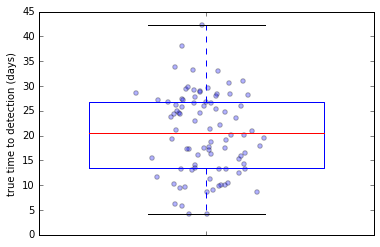

In [24]:
#true time to detection in trial
true_ttd = tr_ctl.fp_ts[tr_ctl.fp_ts>0]-tr_ctl.ex_ts[tr_ctl.fp_ts>0]

plt.boxplot(true_ttd,widths=0.7)
plt.scatter(np.random.normal(1,0.1,len(true_ttd)),true_ttd,alpha=0.3)
plt.xticks([1],[])
plt.ylabel('true time to detection (days)')

In [60]:
#maybe go back and remake to calculate the actual concentration at breakthrough, 
#see if we can infer that from the various readouts too

In [4]:
#now do global sensitivity analyses!

nts=100

iv=10**np.random.uniform(0,3,[nts])
rf=np.random.random([nts])
mx=50+10**np.random.uniform(0,4,[nts])
A0=np.random.randint(0,20,[nts])

tr10=[]
tr30=[]
counter=0
for ii in range(nts):
    tr10.append(AMPmodule.trial(name='d10_'+str(counter), nps=N, tF=560, 
                       dose=10, clade='bimodal', 
                       rfrac=rf[ii], A0=A0[ii], iv_phi=iv[ii], maxIC50=mx[ii], 
                           v_flg=False, keep_flg=0))
    
    tr30.append(AMPmodule.trial(name='d30_'+str(counter), nps=N, tF=560, 
                       dose=30, clade='bimodal', 
                       rfrac=rf[ii], A0=A0[ii], iv_phi=iv[ii], maxIC50=mx[ii], 
                           v_flg=False, keep_flg=0))
    counter+=1
    print(counter)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


0.187749926377
0.611103885998


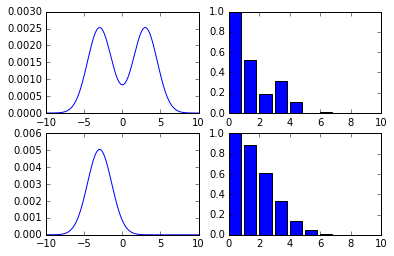

In [187]:
#do a little test on bimodal statistics
x=np.linspace(-10,10,1000);
mu1=-3; mu2=3;
p=np.exp(-(x-mu1)**2/5)+np.exp(-(x-mu2)**2/5)
p=p/np.sum(p)

plt.subplot(221)
plt.plot(x,p)

FT=np.abs(np.fft.fft(p))[:10]

plt.subplot(222)
plt.bar(np.arange(10),FT)
print(FT[2]/FT[0])

p=np.exp(-(x-mu1)**2/5)
p=p/np.sum(p)
FT=np.abs(np.fft.fft(p))[:10]

plt.subplot(223)
plt.plot(x,p)

plt.subplot(224)
plt.bar(np.arange(10),FT)
print(FT[2]/FT[0])


In [310]:
#do a bit more analysis for output variables

PE=np.zeros([2,nts])
PE1=np.zeros([2,nts])
PE2=np.zeros([2,nts])

fpvls_avg=np.zeros([2,nts]); fpvls_std=np.zeros([2,nts]);
IC50s_avg=np.zeros([2,nts]); IC50s_std=np.zeros([2,nts]);

for it in range(nts):    
    
    for ii in range(2):
        
        if ii==0:
            tr=tr10[it]
        else:
            tr=tr30[it]

        fpvls=np.log10(tr.fp_vs[tr.fp_vs>0])
        fpis=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2 #first positive indicies
        fpts=tr.fp_ts[tr.fp_vs>0]
        
        #rescale the IC50 so its actually what will be measured
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #now trial summary outcomes
        PE[ii,it]=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)
        
        fpvls_avg[ii,it]=np.nanmean(fpvls)
        fpvls_std[ii,it]=np.nanstd(fpvls)

        IC50s_avg[ii,it]=np.nanmean(IC50s)
        IC50s_std[ii,it]=np.nanstd(IC50s)

varz=np.array([np.log10(iv),rf,np.log10(mx),A0])

PE[PE<0]=0 #notice PE can be negative based on control

outcomes=np.array([PE,fpvls_avg,fpvls_std,IC50s_avg,IC50s_std])


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: Mean of empty slice
/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice


In [206]:
np.nanmean(fpvls)

5.1172806197494456

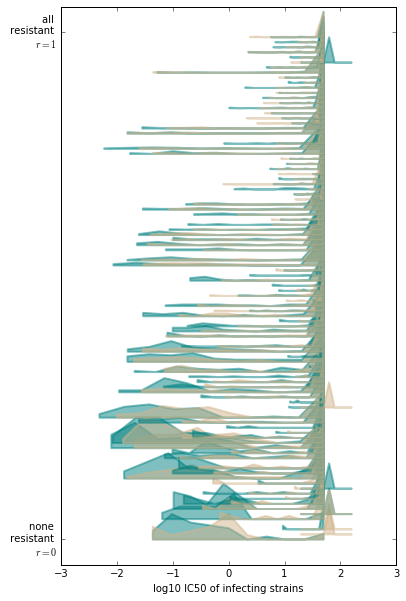

In [413]:
#plot some of these quantities, could be downsampled 
plt.figure(figsize=(6,10))
inds=np.argsort(rf)
pind=0
pindfac=5
trialcolz=['teal','tan']
for it in inds:    
    
    for ii in range(2):
        
        if ii==0:
            tr=tr10[it]
            #plt.ylabel('IC50s of infecting strain log10($\mu$g/mL)')
            #plt.title('low dose arm 10mg/kg',fontsize=10)
            plt.yticks([0,len(inds)/pindfac],['none \n resistant \n $r=0$','all \n resistant \n $r=1$'])
        else:
            tr=tr30[it]
            #plt.title('high dose arm 30mg/kg',fontsize=10)
            #plt.yticks([0,len(inds)/pindfac],[])
 
        #rescale the IC50 so its actually what will be measured
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #plt.violinplot(IC50s,positions=[rf[it]],widths=0.1)
        #plt.scatter(np.ones(len(IC50s))*rf[it],IC50s,lw=0,alpha=0.2,color='navy')
        hh=np.histogram(IC50s,bins=10)
        plt.fill_between(hh[1][1:],hh[0]/max(hh[0])+pind/pindfac,np.ones(len(hh[1][1:]))*pind/pindfac,lw=2,alpha=0.5,color=trialcolz[ii])
        #plt.plot(hh[1][1:],hh[0]/max(hh[0])+pind/3,lw=2)
        #plt.xlabel('fraction resistant, $f$')
        #plt.xlim([-0.1,1.1])
        #now trial summary outcomes
        PE=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)
        plt.ylim([-1,len(inds)/pindfac+1])

    pind+=1
    plt.xlabel('log10 IC50 of infecting strains')    #plt.yticks(range(len(inds)),np.round(rf[inds],2))
plt.savefig('figures/gsense_density-rf.pdf')


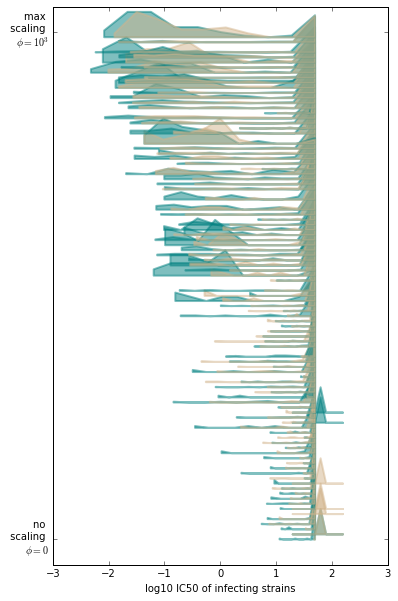

In [414]:
#plot some of these quantities, downsampled!
plt.figure(figsize=(6,10))
inds=np.argsort(iv)
pind=0
pindfac=5
for it in inds:    
    
    for ii in range(2):
        
        if ii==0:
            tr=tr10[it]
            #plt.ylabel('IC50s of infecting strain log10($\mu$g/mL)')
            #plt.title('low dose arm 10mg/kg',fontsize=10)
            plt.yticks([0,len(inds)/pindfac],['no \n scaling \n $\phi=0$','max \n scaling \n $\phi=10^3$'])
        else:
            tr=tr30[it]
            #plt.title('high dose arm 30mg/kg',fontsize=10)
            #plt.yticks([0,len(inds)/pindfac],[])
 
        #rescale the IC50 so its actually what will be measured
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #plt.violinplot(IC50s,positions=[rf[it]],widths=0.1)
        #plt.scatter(np.ones(len(IC50s))*rf[it],IC50s,lw=0,alpha=0.2,color='navy')
        hh=np.histogram(IC50s,bins=10)
        plt.fill_between(hh[1][1:],hh[0]/max(hh[0])+pind/pindfac,np.ones(len(hh[1][1:]))*pind/pindfac,lw=2,alpha=0.5,color=trialcolz[ii])
        #plt.plot(hh[1][1:],hh[0]/max(hh[0])+pind/3,lw=2)
        #plt.xlabel('fraction resistant, $f$')
        #plt.xlim([-0.1,1.1])
        #now trial summary outcomes
        PE=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)
        plt.ylim([-1,len(inds)/pindfac+1])

    pind+=1
    plt.xlabel('log10 IC50 of infecting strains')    #plt.yticks(range(len(inds)),np.round(rf[inds],2))
    
plt.savefig('figures/gsense_density-phi.pdf')


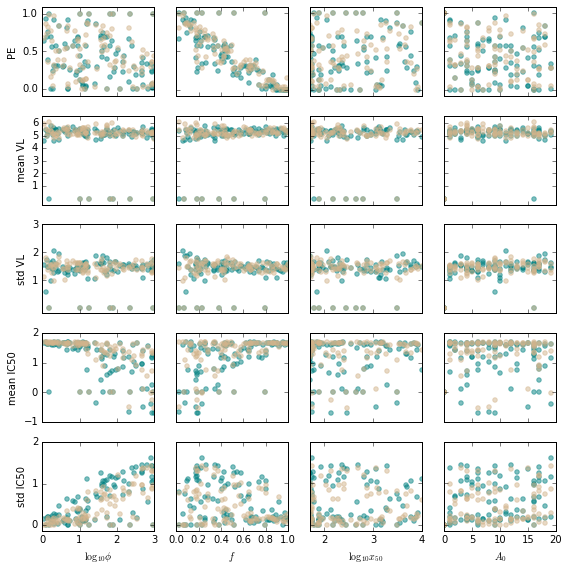

In [410]:
colorz=['gray','navy','coral','skyblue']
outnamez=['PE','mean VL','std VL','mean IC50','std IC50']

varnamez=[r'$\log_{10}\phi$',r'$f$',r'$\log_{10}x_{50}$',r'$A_0$']

varz=np.array([np.log10(iv),rf,np.log10(mx),A0])

corrzlist=np.zeros([2,len(varz),len(outcomes)])

markz=['>','s']

ytickz=[[0,0.5,1],
       [1,2,3,4,5,6],
       [1,2,3],
       [-1,0,1,2],
       [0,1,2]]

xtickz=[[0,1,2,3],
       [0,0.2,0.4,0.6,0.8,1],
       [2,3,4],
       [0,5,10,15,20]]

plt.figure(figsize=(8,8))
pind=1
for o in range(len(outcomes)):
    for v in range(len(varz)):
        plt.subplot(5,4,pind)
        for ii in range(2):
            #plt.subplot(len(outcomes),len(varz),pind)
            #plt.scatter(outcomes[o]/np.nanstd(outcomes[o]),varz[v],color=colorz[v])

            yout=outcomes[o,ii,~np.isnan(outcomes[o,ii])]
            #yout=(yout-np.mean(yout))/np.std(yout)

            xout=varz[v,~np.isnan(outcomes[o,ii])]

            plt.scatter(xout,yout,color=trialcolz[ii],alpha=0.5)
            corrz=st.pearsonr(xout,yout)

            plt.xlim([min(xout),max(xout)])
            #plt.locator_params(axis='x',nbins=4)
            
            if corrz[1]<0.05:
                pp='*'
            if corrz[1]<0.01:
                pp='**'
            if corrz[1]<0.001:
                pp='***'

            corrzlist[ii,v,o]=corrz[0]

            #plt.ylim([ytickz[o][0],ytickz[o][-1]])
            if pind%4!=1:
                plt.yticks(ytickz[o],[])
            else:
                plt.ylabel(outnamez[o],fontsize=10)
                plt.yticks(ytickz[o])
            
            if pind>16:
                plt.xlabel(varnamez[v])
                plt.xticks(xtickz[v])
            else:
                plt.xticks(xtickz[v],[])

            #plt.ylim([-3,3])
            #plt.title(r'$r^2=$' + str(np.round(corrz[0]**2,3))+pp,fontsize=10)
            #calculate correlation
        pind+=1

        plt.tight_layout()
plt.savefig('figures/gsense_corrplots.pdf')


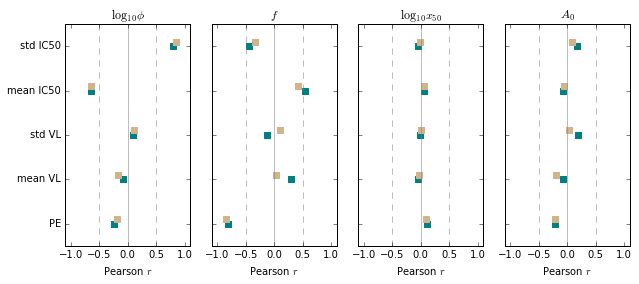

In [409]:
#plot bar plot
plt.figure(figsize=(9,4))
for ii in range(2):
    for v in range(len(varz)):

        plt.subplot(1,4,v+1)

        #plt.barh(corrzlist[ii,v,:],np.arange(len(outcomes)),color=trialcolz[ii])
        plt.scatter(corrzlist[ii,v,:],np.arange(len(outcomes))+ii/10,color=trialcolz[ii],s=30,marker='s')

        if v==0:
            plt.yticks(np.arange(len(outcomes)),outnamez)
        else:
            plt.yticks(np.arange(len(outcomes)),'')

        plt.ylim([-0.5,len(outcomes)-0.5])
        plt.xlim([-1.1,1.1])
        plt.title(varnamez[v])

        plt.axvline(-0.5,ls='--',color='gray',alpha=0.3)
        plt.axvline(0.5,ls='--',color='gray',alpha=0.3)
        plt.axvline(0,ls='-',color='gray',alpha=0.3)
        #plt.grid()
        plt.xlabel('Pearson $r$')

plt.tight_layout()
plt.savefig('figures/gsense_pearsonVARS.pdf')


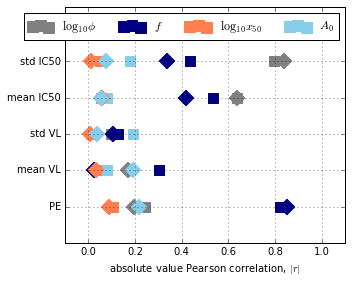

In [408]:
#plot bar plot
plt.figure(figsize=(5,4))
markz=['s','D']
for ii in range(2):
    for v in range(len(varz)):
        plt.scatter(np.abs(corrzlist[ii,v,:]),range(len(outcomes)),color=colorz[v],s=120,marker=markz[ii])
        
plt.yticks(np.arange(len(outcomes)),outnamez)
plt.ylim([-1,len(outcomes)+0.5])
plt.xlim([-0.1,1.1])
#plt.title(varnamez[v])

#plt.axvline(-0.5,ls='--',color='k')
#plt.axvline(0.5,ls='--',color='k')
plt.xlabel('absolute value Pearson correlation, $|r|$')
plt.grid()
plt.legend(varnamez,ncol=4)
plt.tight_layout()
plt.savefig('figures/gsense_pearsonALL.pdf')


exposure week: [ 71.  23.  40.  36.   8.  55.  50.  46.  14.  55.]
exposure interval (1st or 2nd): [ 2.  2.  1.  2.  1.  2.  1.  2.  2.  2.]


TypeError: boxplot() got an unexpected keyword argument 'color'

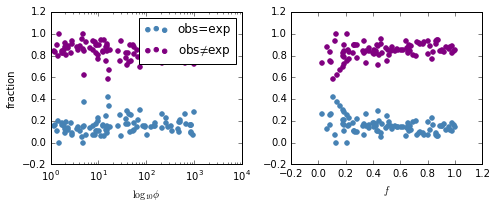

In [422]:
#show how much the delay effect varies across global sensitivity analysis?

#have to figure out if detected interval represents real exposure interval

#check the calculation
print('exposure week:',np.floor(tr_ctl.ex_ts[:10]/7))
print('exposure interval (1st or 2nd):',1+np.floor(tr_ctl.ex_ts[:10]/7/4)%2)

#make the matrix of exposures > detections
def calc_brksmat(tr):
    exts=1+np.floor(tr.ex_ts[tr.fp_ts>0]/7/4)%2
    fpts=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2
    brksmat=np.zeros([2,2])
    for i in range(len(exts)):    
        if exts[i]==1 and fpts[i]==1:
            brksmat[0,0]+=1 #exp 1, det 1
        if exts[i]==1 and fpts[i]==2:
            brksmat[0,1]+=1 #exp 1, det 2
        if exts[i]==2 and fpts[i]==1:
            brksmat[1,0]+=1 #exp 2, det next 1
        if exts[i]==2 and fpts[i]==2:
            brksmat[1,1]+=1 #exp 2, det 2

    return brksmat

#calculate for all trials
obstrue=np.zeros([nts])
obsfalse=np.zeros([nts])
for it in range(nts):    
    tr=tr10[it]

    brksmat=calc_brksmat(tr)
    
    obstrue[it]=(brksmat[0,0]+brksmat[1,1])/np.sum(brksmat)
    obsfalse[it]=(brksmat[0,1]+brksmat[1,0])/np.sum(brksmat)
    
goodind=~np.isnan(obstrue)
obstrue=obstrue[goodind]
obsfalse=obsfalse[goodind]

plt.figure(figsize=(7,3))

plt.subplot(121)
plt.scatter(iv[goodind],obstrue,color='steelblue')
plt.scatter(iv[goodind],obsfalse,color='purple')
plt.semilogx()
plt.xlabel(varnamez[0])
plt.ylabel('fraction')
plt.legend(['obs=exp',r'obs$\ne$exp'])

plt.subplot(122)
plt.scatter(rf[goodind],obstrue,color='steelblue')
plt.scatter(rf[goodind],obsfalse,color='purple')
plt.xlabel(varnamez[1])

plt.tight_layout()
plt.savefig('figures/gsense_delays1.pdf')

#visualize another way
plt.figure(figsize=(4,3))
plt.boxplot([obstrue,obsfalse],positions=[1,2],widths=0.7,color='k')
plt.scatter(np.random.normal(1,0.1,len(obstrue)),obstrue,color='steelblue')
plt.scatter(np.random.normal(2,0.1,len(obsfalse)),obsfalse,color='purple')
#plt.grid()
plt.xticks([1,2],['obs=exp',r'obs$\ne$exp'])
plt.ylabel('fraction across 100 \n global sensitivity analyses')
plt.yticks(np.linspace(0,1,11))
plt.ylim()
plt.tight_layout()

plt.savefig('figures/gsense_delays2.pdf')


/Users/danielreeves/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it cont

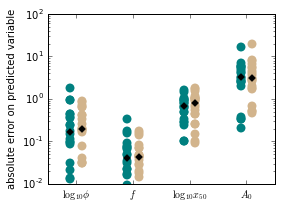

In [418]:
#check on the accuracy of the regression (predictability?)

plt.figure(figsize=(4,3))
outz10=outcomes[:,0]
outz30=outcomes[:,1]
outz10[np.isnan(outz10)]=0 #make sure this is ok, no nans
outz30[np.isnan(outz30)]=0 #make sure this is ok, no nans
    
numpred=20
    
outlist=[outz10,outz30]

for ii in range(2):
    for v in range(len(varz)):    
        reg = slm.LinearRegression()

        #reg.set_params(normalize=True)
        outz=outlist[ii]
        reg.fit(outz.T[:(nts-numpred)],varz[v][:(nts-numpred)])

        #plt.subplot(2,2,v+1)    
        #for i in range(numpred):
        #    plt.scatter(varz[v][-i],reg.predict(outz.T[-i])[0],color=colorz[v],s=30,marker='s')   
        #plt.plot(varz[v],varz[v],ls='-',alpha=0.3,color='k')
        #plt.ylabel(varnamez[v]+' predicted')
        #plt.xlabel(varnamez[v]+' true')
        errz=[]
        for i in range(numpred):
            errz.append(np.abs(varz[v][-i]-reg.predict(outz.T[-i])[0]))

        plt.scatter(np.ones(numpred)*v-0.1+ii/5,errz,lw=0,color=trialcolz[ii],s=80)
        plt.scatter(v-0.1+ii/5,np.median(errz),color='k',marker='D')
    
plt.semilogy()    
plt.xticks(range(4),varnamez)
plt.ylabel('absolute error on predicted variable')
plt.tight_layout()
plt.savefig('figures/gsense_predicted.pdf')
    

In [391]:
reg.predict(outz.T[-i])

/Users/danielreeves/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 11.50352631])

In [357]:
len(X)

506